In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import numpy.ma as ma
import matplotlib.colors as colors
from statistics import mode
import pandas as pd
from scipy import signal
from cartopy.util import add_cyclic_point

home_dir = '/glade/work/devond/'
import sys  
sys.path.insert(0, home_dir)

from functions import * 

crs_sp = ccrs.SouthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()

In [2]:
### ----- Read ICE SHEET MASK data ----- ###
mask_file = '/glade/work/devond/AIS_masks/model_masks/CESM_masks.nc'
cesm_masks = xr.open_dataset(mask_file)
cesm_masks = cesm_masks.sel(lat = slice(-90,-60))

cesm_ism = cesm_masks.full_ism.values #full ice sheet
cesm_ism[cesm_ism>0] = 1
cesm_area = cesm_masks.area.values #grid cell areas

lon = cesm_masks.lon
lat = cesm_masks.lat
cesm_ism2, lon2 = add_cyclic_point(cesm_ism, coord=lon)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


In [40]:
cesm2_lh = xr.open_dataset(f'/glade/work/devond/CESM/turbulent_fluxes/CESM2_LHFLX_hist.nc')['LHFLX']
cesm2_lh = cesm2_lh.sel(lat = slice(-90,-60), time = slice('1979-01-01','2015-01-01'))
cesm2_lh_map = (cesm2_lh*cesm_ism).groupby(cesm2_lh.time.dt.year).mean().mean(dim = ['year', 'ensemble'])

cesm2_sh = xr.open_dataset(f'/glade/work/devond/CESM/turbulent_fluxes/CESM2_SHFLX_hist.nc')['SHFLX']
cesm2_sh = cesm2_sh.sel(lat = slice(-90,-60), time = slice('1979-01-01','2015-01-01'))
cesm2_sh_map = (cesm2_sh*cesm_ism).groupby(cesm2_sh.time.dt.year).mean().mean(dim = ['year', 'ensemble'])

cesm1_lh = xr.open_dataset(f'/glade/work/devond/CESM/turbulent_fluxes/CESM1lens_LHFLX_hist2.nc')['LHFLX']
cesm1_lh = cesm1_lh.sel(lat = slice(-90,-60), time = slice('1979-01-01','2015-01-01'))
cesm1_lh_map = (cesm1_lh*cesm_ism).groupby(cesm1_lh.time.dt.year).mean().mean(dim = ['year', 'ensemble'])

cesm1_sh = xr.open_dataset(f'/glade/work/devond/CESM/turbulent_fluxes/CESM1lens_SHFLX_hist2.nc')['SHFLX']
cesm1_sh = cesm1_sh.sel(lat = slice(-90,-60), time = slice('1979-01-01','2015-01-01'))
cesm1_sh_map = (cesm1_sh*cesm_ism).groupby(cesm1_sh.time.dt.year).mean().mean(dim = ['year', 'ensemble'])


/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [20]:
cesm2_sh_year_mean = cesm2_sh.groupby(cesm2_sh.time.dt.year).mean()
cesm2_sh_ts = (cesm2_sh_year_mean*cesm_ism*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_ism*cesm_area)

cesm1_sh_year_mean = cesm1_sh.groupby(cesm1_sh.time.dt.year).mean()
cesm1_sh_ts = (cesm1_sh_year_mean*cesm_ism*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_ism*cesm_area)

cesm2_lh_year_mean = cesm2_lh.groupby(cesm2_lh.time.dt.year).mean()
cesm2_lh_ts = (cesm2_lh_year_mean*cesm_ism*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_ism*cesm_area)

cesm1_lh_year_mean = cesm1_lh.groupby(cesm1_lh.time.dt.year).mean()
cesm1_lh_ts = (cesm1_lh_year_mean*cesm_ism*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_ism*cesm_area)

In [30]:
cesm2_sh_mean = cesm2_sh_ts.mean()
cesm2_sh_std = cesm2_sh_ts.std(dim = 'year').mean()

cesm1_sh_mean = cesm1_sh_ts.mean()
cesm1_sh_std = cesm1_sh_ts.std(dim = 'year').mean()

cesm2_lh_mean = cesm2_lh_ts.mean()
cesm2_lh_std = cesm2_lh_ts.std(dim = 'year').mean()

cesm1_lh_mean = cesm1_lh_ts.mean()
cesm1_lh_std = cesm1_lh_ts.std(dim = 'year').mean()

sh_bias = (cesm2_sh_mean - cesm1_sh_mean).values
sh_uncertainty = np.sqrt((cesm2_sh_std**2 + cesm1_sh_std**2)).values
print(f'CESM2 SHF is {sh_bias:0.1f} +/- {sh_uncertainty:0.1f} W/m2 different than CESM1')

lh_bias = (cesm2_lh_mean - cesm1_lh_mean).values
lh_uncertainty = np.sqrt((cesm2_lh_std**2 + cesm1_lh_std**2)).values
print(f'CESM2 LHF is {lh_bias:0.1f} +/- {lh_uncertainty:0.1f} W/m2 different than CESM1')

CESM2 SHF is -4.0 +/- 0.4 W/m2 different than CESM1
CESM2 LHF is 1.1 +/- 0.1 W/m2 different than CESM1


In [38]:
cesm2_lh_map, lon2 = add_cyclic_point(cesm2_lh_map, coord=lon)
cesm2_sh_map, lon2 = add_cyclic_point(cesm2_sh_map, coord=lon)
cesm1_lh_map, lon2 = add_cyclic_point(cesm1_lh_map, coord=lon)
cesm1_sh_map, lon2 = add_cyclic_point(cesm1_sh_map, coord=lon)


TypeError: mean() got an unexpected keyword argument 'dim'

TypeError: mean() got an unexpected keyword argument 'dim'

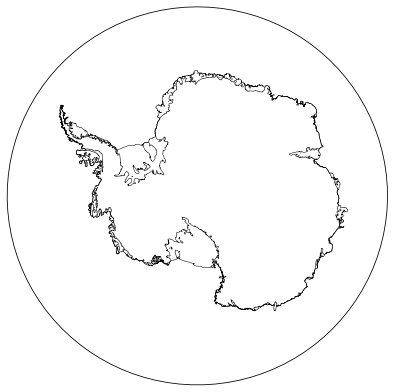

In [36]:
fig = plt.figure(figsize = (20,15))
gs=GridSpec(2,2)
plt.rcParams['axes.titlepad'] =14

ax1 = plt.subplot(gs[0,0],projection=crs_sp)
plot_antarctica(ax1,-60)
im = ax1.pcolormesh(lon2, lat, cesm2_lh_map*cesm_ism2, cmap = 'inferno',transform = crs_ll, vmin = 0, vmax = 10)
ax1.set_title('CESM2 Latent heat flux', fontsize = 20)
cb = plt.colorbar(im, shrink = 0.9, extend = 'both')
cb.set_label('$W~m^{-2}$', fontsize = 16)
cb.ax.tick_params(labelsize=14)
ax1.text(0, 1.08, '(a)', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax2 = plt.subplot(gs[0,1],projection=crs_sp)
plot_antarctica(ax2,-60)
im2 = ax2.pcolormesh(lon2, lat, (cesm2_lh_map - cesm1_lh_map)*cesm_ism2, cmap = 'RdBu_r',transform = crs_ll, vmin = -10, vmax = 10)
ax2.set_title('CESM2 - CESM1 Latent heat flux', fontsize = 20)
cb = plt.colorbar(im2, shrink = 0.9, extend = 'both')
cb.set_label('$W~m^{-2}$', fontsize = 16)
cb.ax.tick_params(labelsize=14)
ax2.text(0, 1.08, '(b)', transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax3 = plt.subplot(gs[1,0],projection=crs_sp)
plot_antarctica(ax3,-60)
im3 = ax3.pcolormesh(lon2, lat, cesm2_sh_map*cesm_ism2, cmap = 'inferno',transform = crs_ll, vmin = -40, vmax = 0)
ax3.set_title('CESM2 Sensible heat flux', fontsize = 20)
cb = plt.colorbar(im3, shrink = 0.9, extend = 'both')
cb.set_label('$W~m^{-2}$', fontsize = 16)
cb.ax.tick_params(labelsize=14)
ax3.text(0, 1.08, '(c)', transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax4 = plt.subplot(gs[1,1],projection=crs_sp)
plot_antarctica(ax4,-60)
im4 = ax4.pcolormesh(lon2, lat, (cesm2_sh_map - cesm1_sh_map)*cesm_ism2, cmap = 'RdBu_r',transform = crs_ll, vmin = -15, vmax = 15)
ax4.set_title('CESM2 - CESM1 Sensible heat flux', fontsize = 20)
cb = plt.colorbar(im4, shrink = 0.9, extend = 'both')
cb.set_label('$W~m^{-2}$', fontsize = 16)
cb.ax.tick_params(labelsize=14)
ax4.text(0, 1.08, '(d)', transform=ax4.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')


plt.savefig('turbulent_bias_maps.png', dpi = 300, bbox_inches = 'tight')

In [9]:
cesm2_lh_month = (cesm2_lh*cesm_area*cesm_ism).sum(dim = ['lat','lon']).mean(dim = 'ensemble')/np.nansum(cesm_area*cesm_ism)
cesm2_lh_month = cesm2_lh_month.groupby(cesm2_lh_month.time.dt.month).mean()

cesm2_sh_month = (cesm2_sh*cesm_area*cesm_ism).sum(dim = ['lat','lon']).mean(dim = 'ensemble')/np.nansum(cesm_area*cesm_ism)
cesm2_sh_month = cesm2_sh_month.groupby(cesm2_sh_month.time.dt.month).mean()

cesm1_lh_month = (cesm1_lh*cesm_area*cesm_ism).sum(dim = ['lat','lon']).mean(dim = 'ensemble')/np.nansum(cesm_area*cesm_ism)
cesm1_lh_month = cesm1_lh_month.groupby(cesm1_lh_month.time.dt.month).mean()

cesm1_sh_month = (cesm1_sh*cesm_area*cesm_ism).sum(dim = ['lat','lon']).mean(dim = 'ensemble')/np.nansum(cesm_area*cesm_ism)
cesm1_sh_month = cesm1_sh_month.groupby(cesm1_sh_month.time.dt.month).mean()


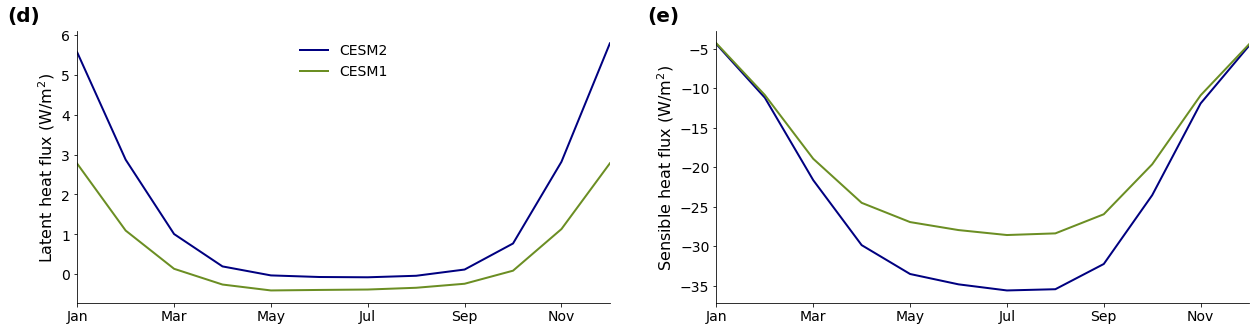

In [14]:
fig, ax = plt.subplots(1,2,figsize = (21,5))

ax[0].plot(cesm2_lh_month, color = 'navy', linewidth = 2, label = 'CESM2')
ax[0].plot(cesm1_lh_month, color = 'olivedrab', linewidth = 2, label = 'CESM1')
ax[0].set_xticks([0,2,4,6,8,10])
ax[0].set_xlim([0,11])
ax[0].set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov'], fontsize = 16)
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].tick_params(labelsize=14)
ax[0].legend(frameon = False, prop={'size':14})
ax[0].set_ylabel('Latent heat flux (W/m$^2$)', fontsize=16)
ax[0].text(-0.07, 1.09, '(d)', transform=ax[0].transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax[1].plot(cesm2_sh_month, color = 'navy', linewidth = 2)
ax[1].plot(cesm1_sh_month, color = 'olivedrab', linewidth = 2)
ax[1].set_xticks([0,2,4,6,8,10])
ax[1].set_xlim([0,11])
ax[1].set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov'], fontsize = 16)
ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].tick_params(labelsize=14)
ax[1].set_ylabel('Sensible heat flux (W/m$^2$)', fontsize=16)
ax[1].text(-0.07, 1.09, '(e)', transform=ax[1].transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

plt.savefig('turbulent_monthly.png', dpi = 300, bbox_inches = 'tight')

In [13]:
print((cesm2_sh_month.mean() - cesm1_sh_month.mean()))
print((cesm2_sh_month.mean()))
print((cesm2_lh_month.mean() - cesm1_lh_month.mean()))
print((cesm2_lh_month.mean()))

<xarray.DataArray 'SHFLX' ()>
array(-3.95465487)
<xarray.DataArray 'SHFLX' ()>
array(-23.26066143)
<xarray.DataArray 'LHFLX' ()>
array(1.07725081)
<xarray.DataArray 'LHFLX' ()>
array(1.5777486)
